In [1]:
%%capture
!git clone https://github.com/naitik-2006/ml4sc

# Import Stuff

In [29]:
import os
import time
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import timm  # timm library provides many pretrained models including hybrid ViT
from tqdm import tqdm  # for progress bars
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from torch.optim.lr_scheduler import OneCycleLR

# Variables

In [3]:
BATCH_SIZE = 32
train_dir = "/content/ml4sc/dataset/train"
test_dir = "/content/ml4sc/dataset/val"

# Custom Dataset

In [4]:
class NpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with subfolders per class (e.g., ./train/class_name/)
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.samples = []  # list of tuples (file_path, label)
        self.transform = transform

        # List subdirectories and assign integer labels
        class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        for class_name in class_names:
            class_folder = os.path.join(root_dir, class_name)
            for fname in os.listdir(class_folder):
                if fname.endswith('.npy'):
                    file_path = os.path.join(class_folder, fname)
                    self.samples.append((file_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]

        # Load .npy image; assume shape is H x W x C (if not, adjust accordingly)
        image = np.load(file_path)

        if image.ndim == 3 and image.shape[-1] in [1, 3]:
            image = np.transpose(image, (2, 0, 1))  # Convert to C x H x W

        if image.shape[0] == 1:  # If image is (1, H, W), expand to (3, H, W)
            image = np.repeat(image, 3, axis=0)  # Repeat across the 3 channels


        image = torch.tensor(image, dtype=torch.float)

        # Normalize if values are above 1 (i.e. in [0,255])
        image = image / 255.0 if image.max() > 1 else image

        if self.transform:
            image = self.transform(image)
        return image, label

# Data Augmentation

In [37]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),                         # Horizontal flip
    transforms.RandomVerticalFlip(),                           # Vertical flip
])


# Utility Function

In [38]:
# ---------------------------
# Utility: Visualize Sample Images from DataLoader
# ---------------------------

def show_sample_images(data_loader, class_names, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_images]
    labels = labels[:num_images]
    # Convert tensor from C x H x W to H x W x C for plotting
    images = images.permute(0, 2, 3, 1).cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis('off')
    plt.show()

# Model

In [40]:
def get_model(num_classes=3):
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)

    # Get the number of input features to the classifier
    in_features = model.get_classifier().in_features

    # Remove the last classification layer and add custom layers
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.1),
        nn.Linear(in_features, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, num_classes),
    )
    return model

In [41]:
# Freeze and Unfreeze Backbone

def freeze_backbone(model):
    # Freeze all parameters except the classification head (assumed to contain 'head' in name)
    unfreeze_backbone(model)
    for name, param in model.named_parameters():
        if 'classifier' not in name:
            param.requires_grad = False
        else :
          break

def unfreeze_backbone(model):
    for param in model.parameters():
        param.requires_grad = True

In [42]:
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Apply softmax for probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = np.argmax(y_scores, axis=1)

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Classification Report
    print('Classification Report:\n', classification_report(y_true, y_pred))

    # Compute ROC Curve and AUC Score
    plt.figure(figsize=(8, 6))
    for i in range(y_scores.shape[1]):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return accuracy

In [44]:
# Training Loop with tqdm, Cosine Annealing Scheduler & Loss Logging

def train_model(model, train_loader, test_loader, num_epochs=15, device='cuda', save_path='./saved_models'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RAdam(model.parameters(), lr=1e-3)  # AdamW for better weight decay handling

    # OneCycleLR dynamically adjusts learning rate
    steps_per_epoch = len(train_loader)  # Total steps per epoch
    scheduler = OneCycleLR(
        optimizer,
        max_lr=5e-3,  # Peak learning rate (tune this)
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,  # First 10% of training: LR increases
        anneal_strategy="cos",
        final_div_factor=100  # Final LR = max_lr / 100
    )

    # Freeze backbone for initial epochs
    freeze_backbone(model)
    print(f"Pretrained backbone frozen for first epochs.")

    # Create directory to save models
    os.makedirs(save_path, exist_ok=True)

    loss_history = []
    epoch_times = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        epoch_start_time = time.time()
        images_count = 0

        # Training loop with tqdm progress bar
        train_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            images_count += images.size(0)

            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            train_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{(correct_train / total_train) * 100:.2f}%",
                "LR": f"{scheduler.get_last_lr()[0]:.6f}"  # Show changing LR
            })

        epoch_loss = running_loss / images_count
        loss_history.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        # Save model after each epoch
        model_save_path = os.path.join(save_path, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved: {model_save_path}")

        # Unfreeze backbone after freeze_epochs and update scheduler
        if epoch+1 == 1:
            unfreeze_backbone(model)
            print("Unfreezing pretrained backbone. Now training the entire model.")
        if epoch+1 > 1:
            scheduler.step()

        evaluate_model(model, test_loader, device)

    # Plot training loss vs. epochs
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss vs. Epochs")
    plt.grid(True)
    plt.show()

    return loss_history, epoch_times

# Main Code

In [45]:
train_dataset = NpyDataset(train_dir, transform=train_transform)
test_dataset = NpyDataset(test_dir)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = list(train_dataset.class_to_idx.keys())

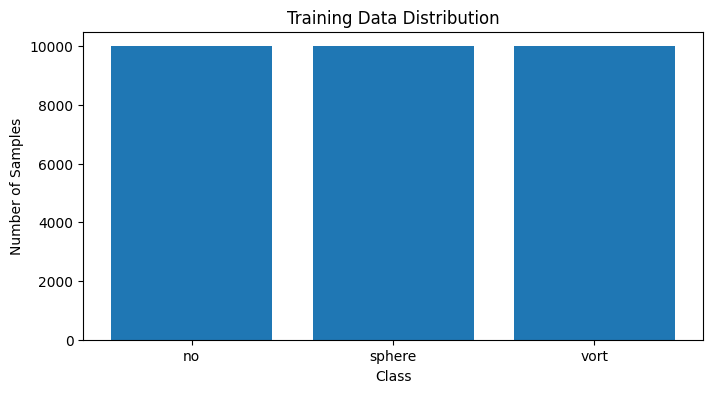

In [ ]:
# Plot distribution of classes in the training set

class_counts = {cls: 0 for cls in train_dataset.class_to_idx.keys()}
for _, label in train_dataset:
    for cls, idx in train_dataset.class_to_idx.items():
        if label == idx:
            class_counts[cls] += 1

plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Training Data Distribution")
plt.show()

Showing sample images from training data:


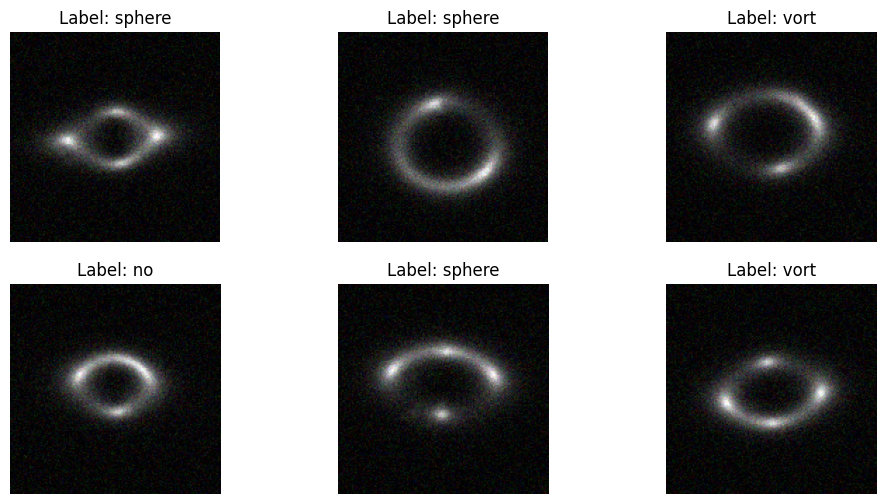

Showing sample images from test data:


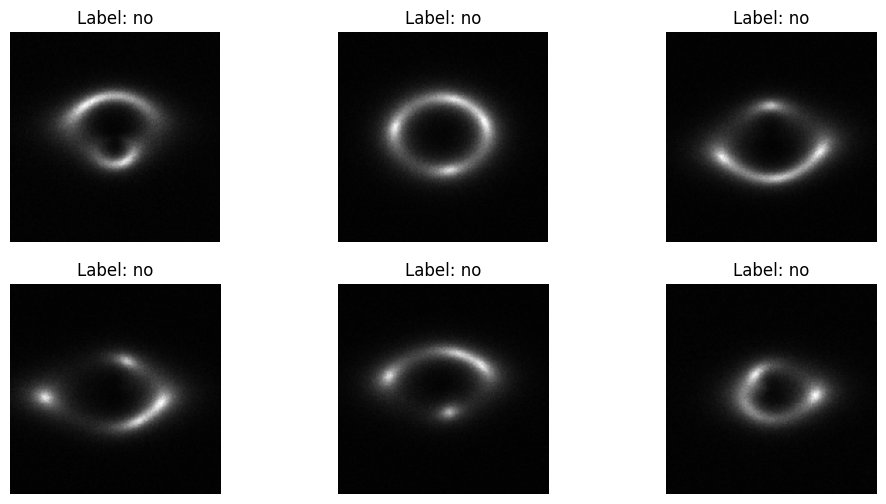

In [34]:
# Visualize sample images from train and test to ensure DataLoader works
print("Showing sample images from training data:")
show_sample_images(train_loader, class_names, num_images=6)
print("Showing sample images from test data:")
show_sample_images(test_loader, class_names, num_images=6)

In [46]:
# Get the pretrained model
model = get_model()

Pretrained backbone frozen for first epochs.


Model saved: ./saved_models/model_epoch_1.pth
Unfreezing pretrained backbone. Now training the entire model.
Accuracy: 0.3776
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.54      0.46      2500
           1       0.36      0.22      0.28      2500
           2       0.37      0.36      0.37      2500

    accuracy                           0.38      7500
   macro avg       0.37      0.38      0.37      7500
weighted avg       0.37      0.38      0.37      7500



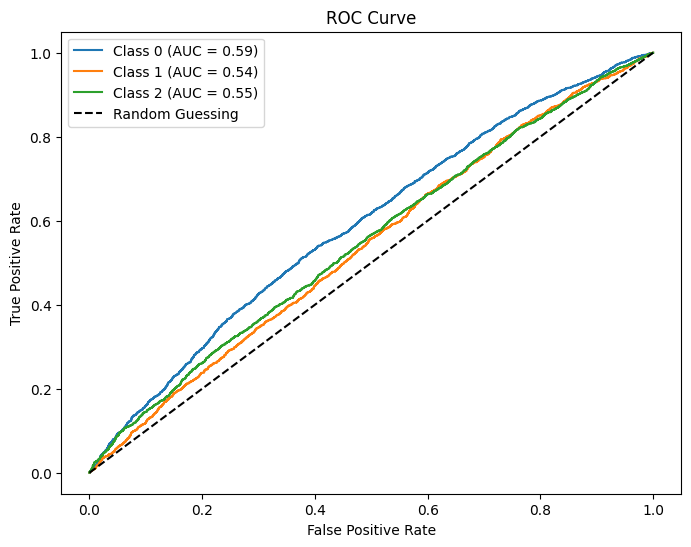

Model saved: ./saved_models/model_epoch_2.pth
Accuracy: 0.5488
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.88      0.66      2500
           1       0.54      0.43      0.48      2500
           2       0.65      0.33      0.44      2500

    accuracy                           0.55      7500
   macro avg       0.57      0.55      0.52      7500
weighted avg       0.57      0.55      0.52      7500



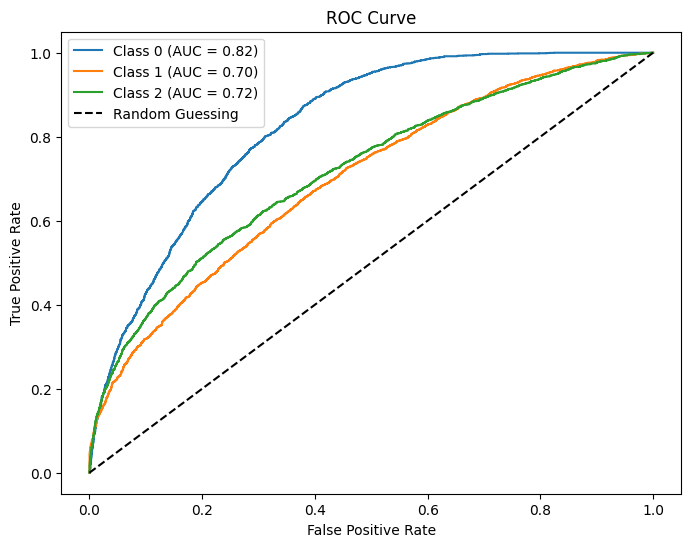

Model saved: ./saved_models/model_epoch_3.pth
Accuracy: 0.6684
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.94      0.75      2500
           1       0.79      0.40      0.53      2500
           2       0.67      0.67      0.67      2500

    accuracy                           0.67      7500
   macro avg       0.70      0.67      0.65      7500
weighted avg       0.70      0.67      0.65      7500



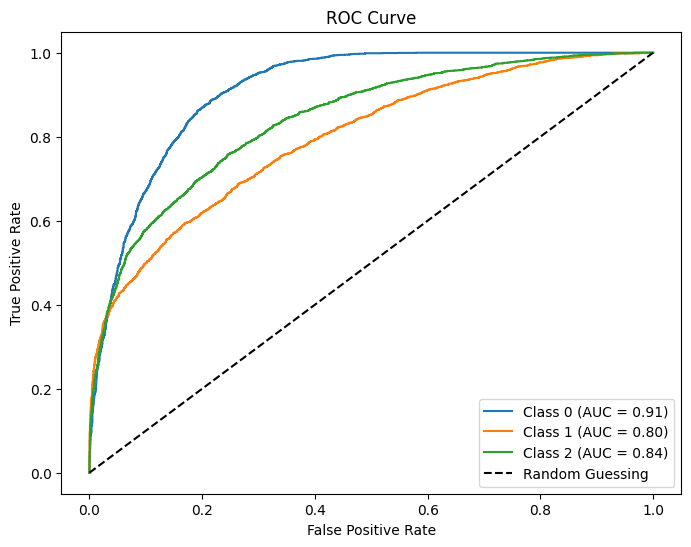

Model saved: ./saved_models/model_epoch_4.pth
Accuracy: 0.7592
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82      2500
           1       0.68      0.73      0.71      2500
           2       0.83      0.69      0.75      2500

    accuracy                           0.76      7500
   macro avg       0.76      0.76      0.76      7500
weighted avg       0.76      0.76      0.76      7500



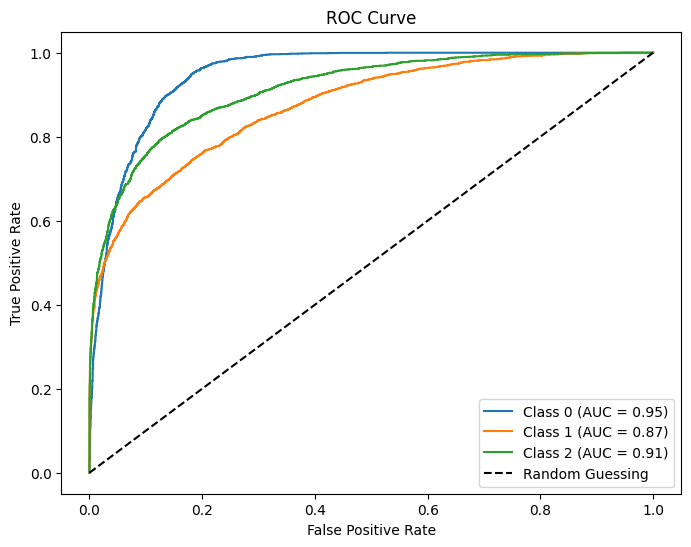

Model saved: ./saved_models/model_epoch_5.pth


Accuracy: 0.7909
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      2500
           1       0.70      0.80      0.75      2500
           2       0.88      0.71      0.78      2500

    accuracy                           0.79      7500
   macro avg       0.80      0.79      0.79      7500
weighted avg       0.80      0.79      0.79      7500



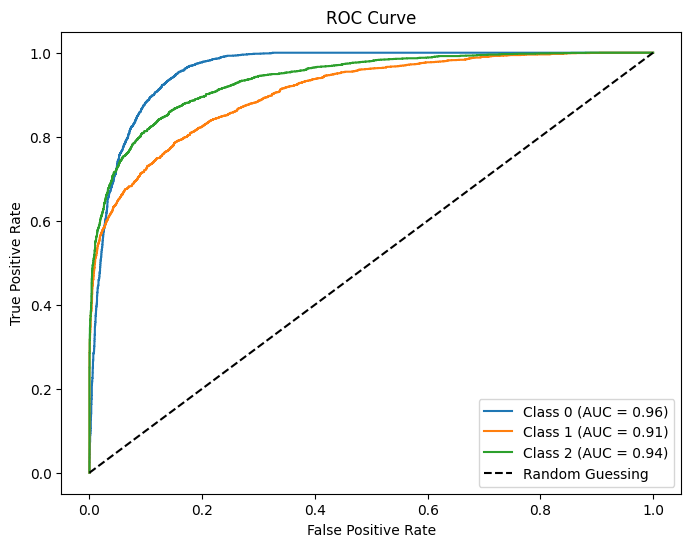

Model saved: ./saved_models/model_epoch_6.pth
Accuracy: 0.8291
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      2500
           1       0.88      0.68      0.77      2500
           2       0.81      0.87      0.84      2500

    accuracy                           0.83      7500
   macro avg       0.83      0.83      0.83      7500
weighted avg       0.83      0.83      0.83      7500



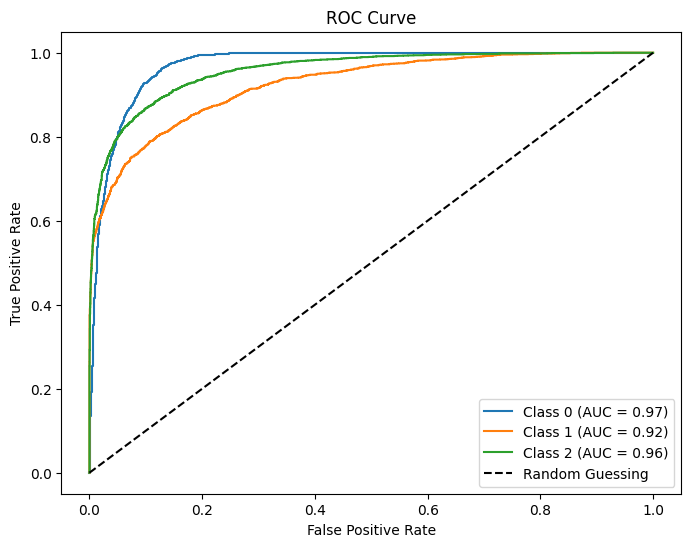

Model saved: ./saved_models/model_epoch_7.pth
Accuracy: 0.8509
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      2500
           1       0.82      0.82      0.82      2500
           2       0.86      0.86      0.86      2500

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500



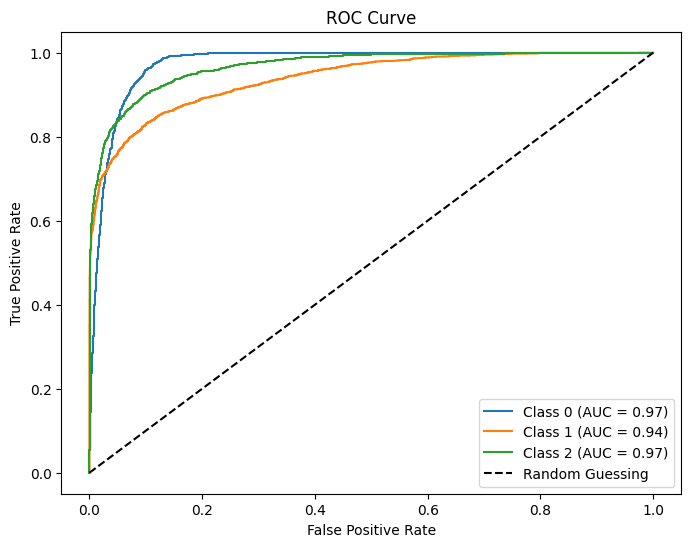

Model saved: ./saved_models/model_epoch_8.pth
Accuracy: 0.8831
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.90      2500
           1       0.89      0.81      0.85      2500
           2       0.90      0.89      0.89      2500

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



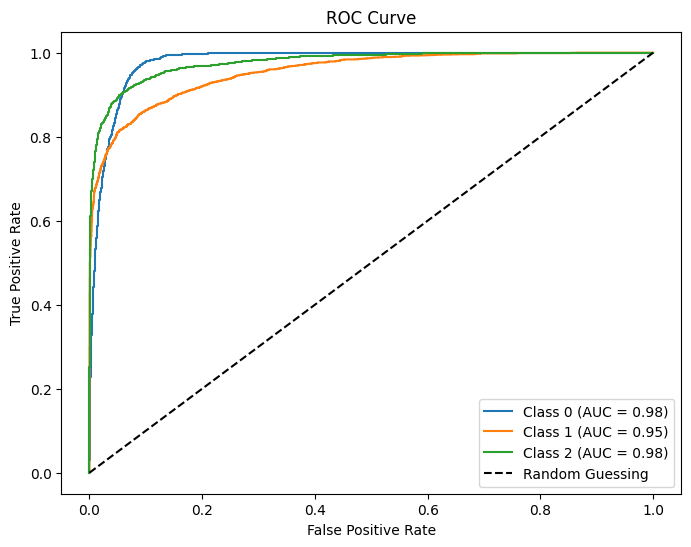

Model saved: ./saved_models/model_epoch_9.pth
Accuracy: 0.8745
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      2500
           1       0.81      0.87      0.84      2500
           2       0.94      0.83      0.88      2500

    accuracy                           0.87      7500
   macro avg       0.88      0.87      0.88      7500
weighted avg       0.88      0.87      0.88      7500



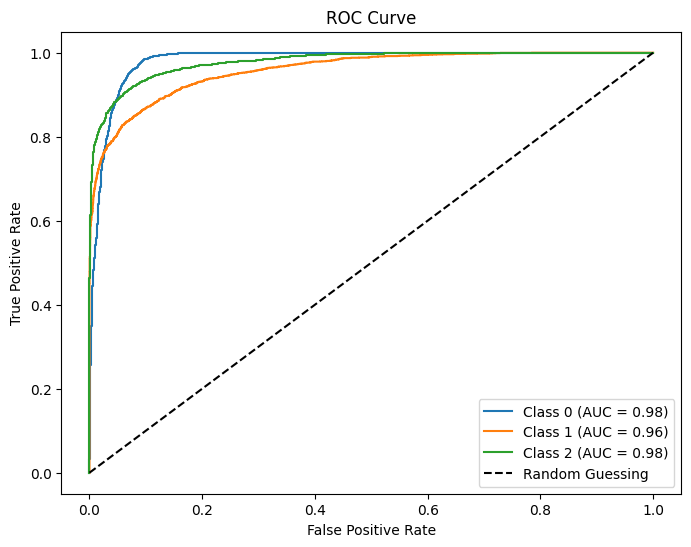

Model saved: ./saved_models/model_epoch_10.pth


Accuracy: 0.8955
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      2500
           1       0.90      0.83      0.86      2500
           2       0.91      0.90      0.91      2500

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.89      7500
weighted avg       0.90      0.90      0.89      7500



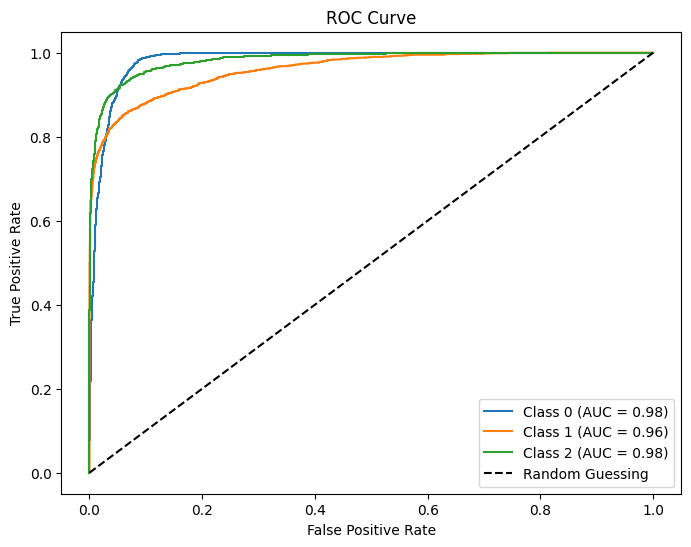

Model saved: ./saved_models/model_epoch_11.pth
Accuracy: 0.8849
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      2500
           1       0.83      0.88      0.85      2500
           2       0.92      0.90      0.91      2500

    accuracy                           0.88      7500
   macro avg       0.89      0.88      0.89      7500
weighted avg       0.89      0.88      0.89      7500



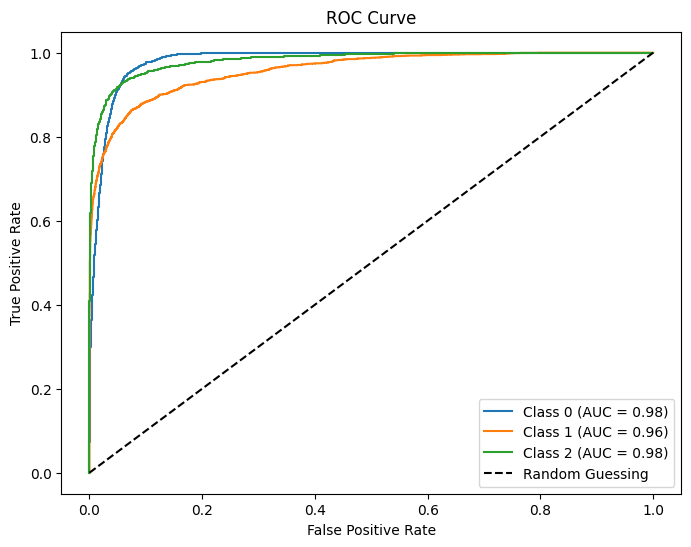

Model saved: ./saved_models/model_epoch_12.pth
Accuracy: 0.8923
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2500
           1       0.90      0.84      0.87      2500
           2       0.90      0.90      0.90      2500

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500



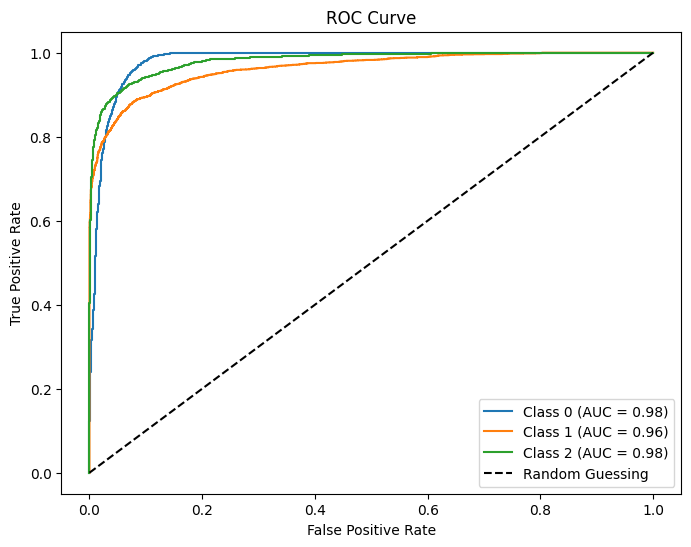

Model saved: ./saved_models/model_epoch_13.pth
Accuracy: 0.9144
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      2500
           1       0.90      0.87      0.89      2500
           2       0.94      0.92      0.93      2500

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500



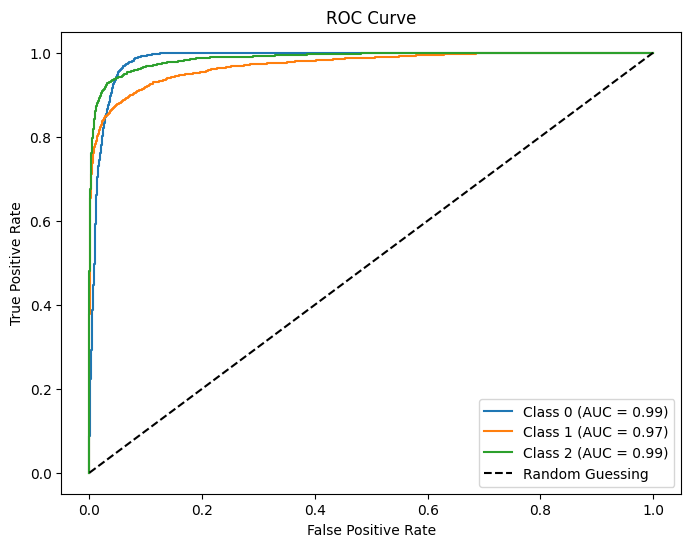

Model saved: ./saved_models/model_epoch_14.pth
Accuracy: 0.9113
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      2500
           1       0.88      0.89      0.89      2500
           2       0.95      0.89      0.92      2500

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500



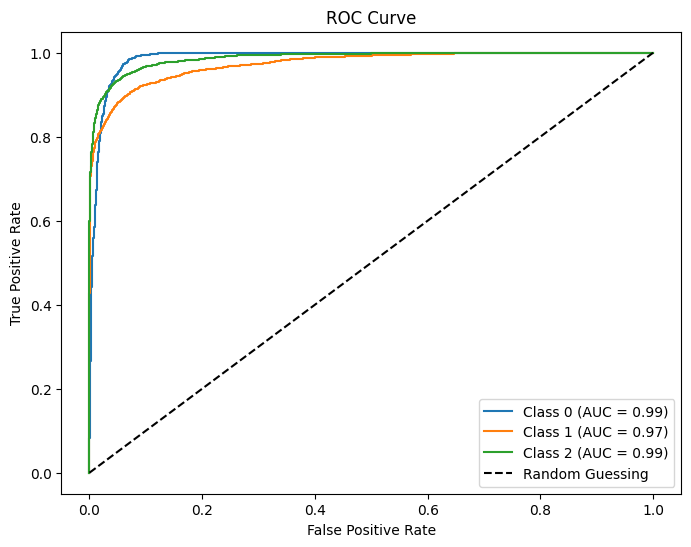

Model saved: ./saved_models/model_epoch_15.pth
Accuracy: 0.9129
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93      2500
           1       0.93      0.85      0.89      2500
           2       0.91      0.94      0.92      2500

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500



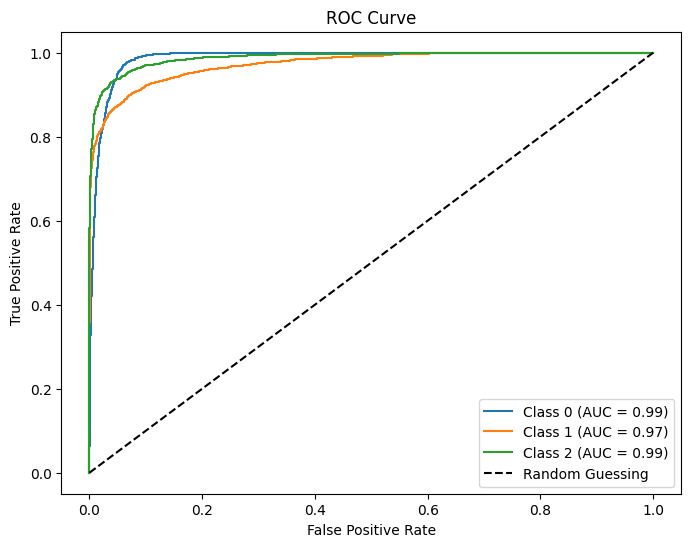

Model saved: ./saved_models/model_epoch_16.pth


Accuracy: 0.9183
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      2500
           1       0.94      0.85      0.89      2500
           2       0.92      0.94      0.93      2500

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



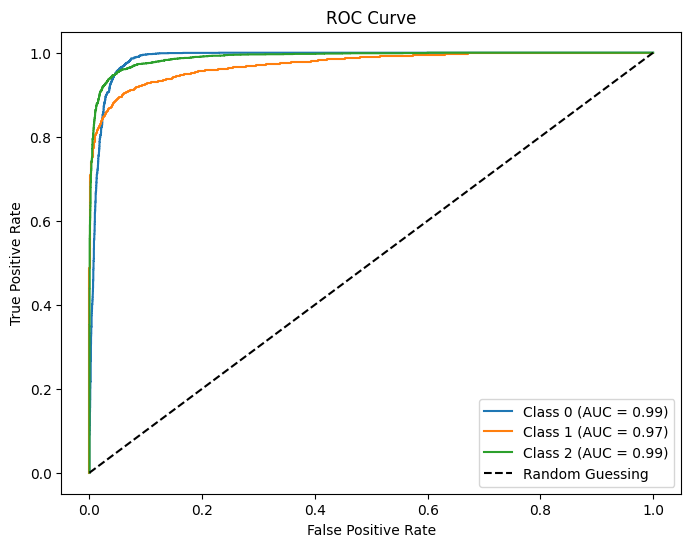

Model saved: ./saved_models/model_epoch_17.pth


Accuracy: 0.9280
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      2500
           1       0.94      0.88      0.90      2500
           2       0.95      0.93      0.94      2500

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500



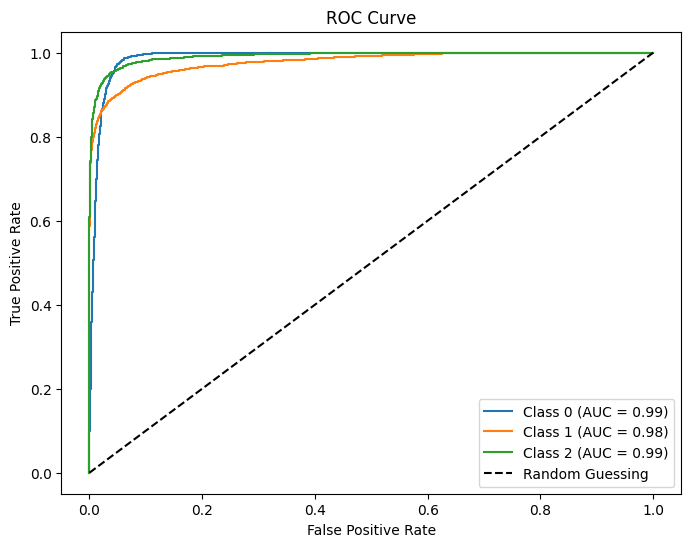

Model saved: ./saved_models/model_epoch_18.pth
Accuracy: 0.9161
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      2500
           1       0.95      0.85      0.89      2500
           2       0.89      0.95      0.92      2500

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



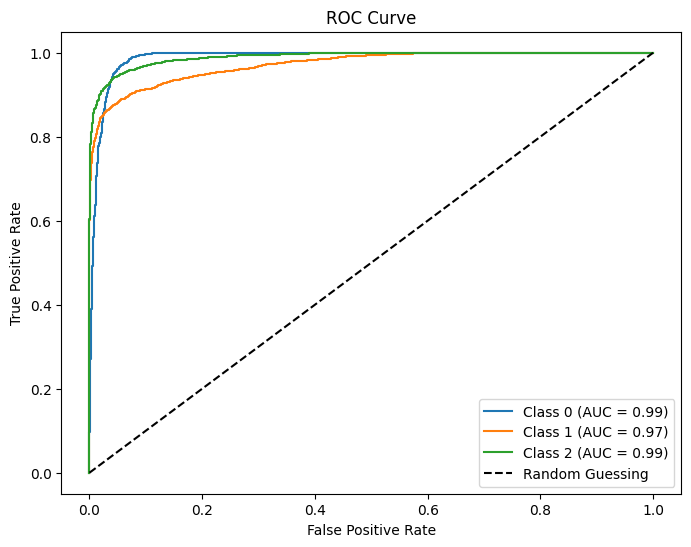

Model saved: ./saved_models/model_epoch_19.pth


Accuracy: 0.9112
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      2500
           1       0.88      0.88      0.88      2500
           2       0.92      0.93      0.93      2500

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500



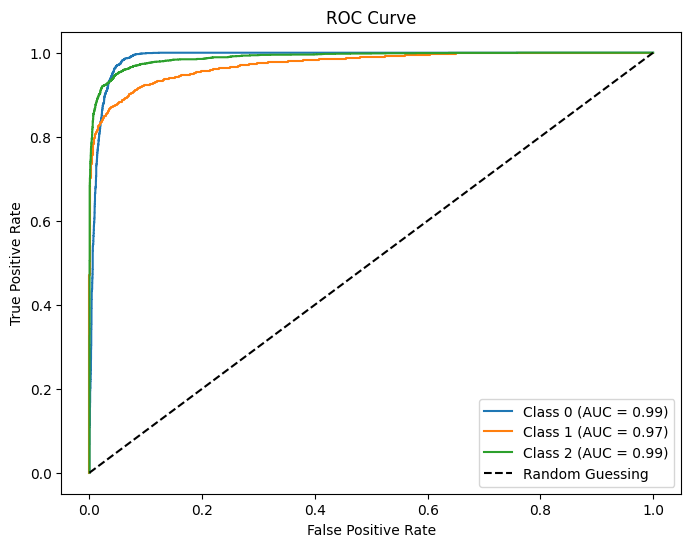

Model saved: ./saved_models/model_epoch_20.pth


Accuracy: 0.9225
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      2500
           1       0.95      0.85      0.90      2500
           2       0.93      0.93      0.93      2500

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



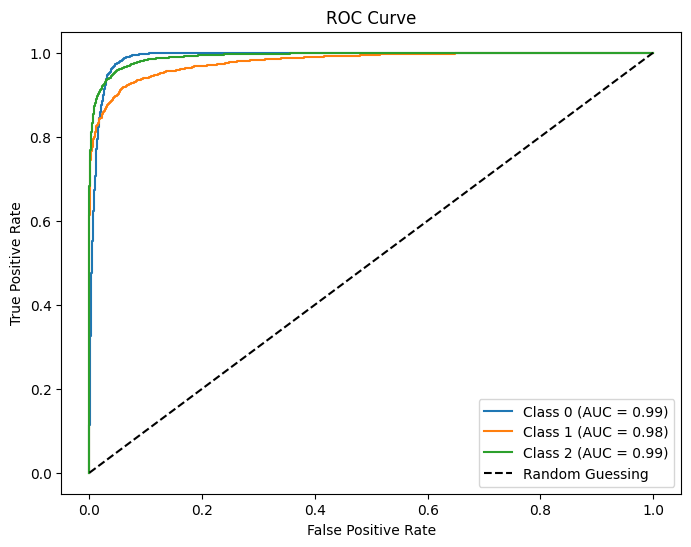

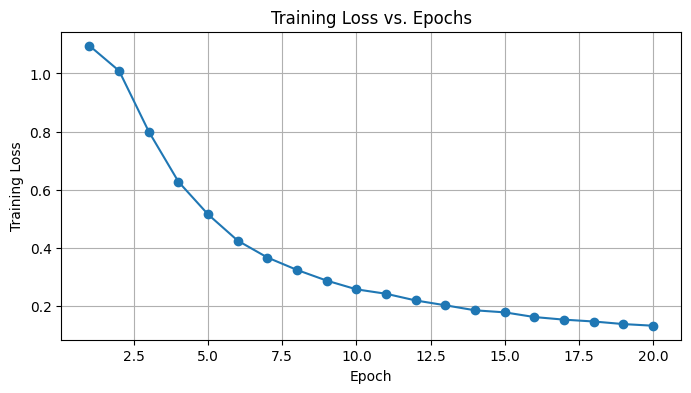

In [47]:
# Train the model with freezing + cosine annealing
loss_history, epoch_times = train_model(model, train_loader, test_loader, num_epochs=20,  device='cuda')